In [ ]:
stock = 'TSLA' # input('Please enter Ticker Symbol(e.g. AAPL) & Press Enter: ')

In [ ]:
 
# libraries
import time
import pandas as pd
import numpy as np
 
 
# time handling
now = int(time.time()) 
now =str(now)
days_delta = int(time.time()) - 8640000 * 2
days =str(days_delta)
# calling from finnhub.io API
import requests
r = requests.get('https://finnhub.io/api/v1/stock/candle?symbol='+stock+'&from='+days+'&to='+now+'&resolution=D&token=c36j4jqad3ifoi8hsu50')
#json conversion
j = r.json() 
df = pd.DataFrame.from_dict(j)
 
# handling time
df.t = (pd.to_datetime(df['t'],unit='s'))
df
 
#table display
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.c, df.h, df.l, df.o, df.s,df.t,df.v],
               fill_color='lavender',
               align='left'))
])
 
#fig.show()
# display stock prices
import plotly.express as px
fig = px.line(df,x='t',y='c', template='plotly_dark')
fig.add_trace(go.Scatter(x=df.t,y=df.l, mode="lines",name='Low'))
fig.add_trace(go.Scatter(x=df.t, y=df.h, mode="lines",name='High'))
fig.update_layout(title=stock+' Stock Price data for the last 140 Days')
fig.update_yaxes(title='$ Closing Value')
fig.show()

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df['t'],
                open=df['o'],
                high=df['h'],
                low=df['l'],
                close=df['c'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.update_layout(title=stock+' Stock Price candlestick data for the last 140 Days')
fig.update_layout(template='plotly_dark')
fig.update_yaxes(title='$')
fig.show()

In [ ]:
df = df[['t','c']]
df.set_index(df.t,inplace=True)
df = df[['c']]

## ARIMA Model

In [ ]:
pip install --user scipy==1.2.0

  Using cached scipy-1.2.0-cp37-cp37m-manylinux1_x86_64.whl (26.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 1.8.2 requires scipy>=1.3.2, but you have scipy 1.2.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
pip install pmdarima

  Using cached scipy-1.7.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:

from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [ ]:
adf_test(df['c'])

1. ADF :  -1.9952646569816892
2. P-Value :  0.2886532341537002
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 135
5. Critical Values :
	 1% :  -3.479742586699182
	 5% :  -2.88319822181578
	 10% :  -2.578319684499314


In [ ]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(df['c'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  137
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -623.378
Date:                Wed, 28 Jul 2021   AIC                           1248.755
Time:                        03:42:44   BIC                           1251.668
Sample:                             0   HQIC                          1249.939
                                - 137                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       560.8535     43.514     12.889      0.000     475.569     646.139
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):                62.45
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
train=df.iloc[:-50]
test=df.iloc[-50:]
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['c'],order=(1,0,5))
model=model.fit()

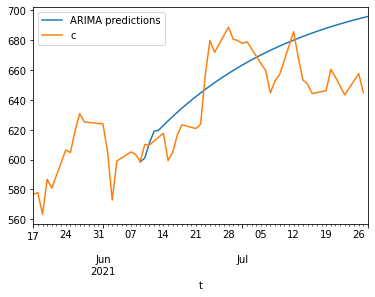

In [ ]:

start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2021-06-09',end='2021-07-28')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test['c'].plot(legend=True)

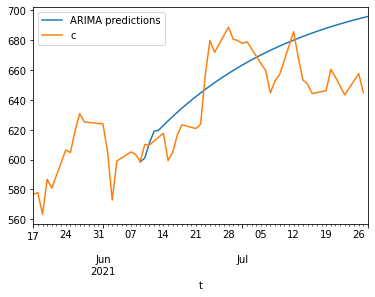

In [ ]:
pred.plot(legend='ARIMA Predictions')
test['c'].plot(legend=True)

In [ ]:
model2=ARIMA(df['c'],order=(1,0,5))
model2=model2.fit()
df.tail()

,c
t,
2021-07-21,655.29
2021-07-22,649.26
2021-07-23,643.38
2021-07-26,657.62
2021-07-27,644.78


In [ ]:
index_future_dates=pd.date_range(start='2021-07-27',end='2021-07-30')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+3,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2021-07-27    646.624723
2021-07-28    650.165416
2021-07-29    652.609492
2021-07-30    653.995621
Freq: D, Name: ARIMA Predictions, dtype: float64


In [ ]:
pred

2021-07-27    646.624723
2021-07-28    650.165416
2021-07-29    652.609492
2021-07-30    653.995621
Freq: D, Name: ARIMA Predictions, dtype: float64

In [ ]:
#https://github.com/nachi-hebbar/ARIMA-Temperature_Forecasting/blob/master/Temperature_Forecast_ARIMA.ipynb

In [ ]:
print(type(pred))

<class 'pandas.core.series.Series'>


In [ ]:
result = pd.DataFrame(pred)
result.tail(1)

,ARIMA predictions
2021-07-28,695.915471


In [ ]:
fig = px.line(df,x=df.index,y='c', template='plotly_dark')
fig.add_trace(go.Scatter(x=result.index, y=result['ARIMA predictions'], mode="lines",name='Prediction'))